In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))  # Go up one level to `project` directory

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import shap
import wandb
import optuna
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, accuracy_score, roc_auc_score
from sklearn.calibration import calibration_curve, CalibrationDisplay
from data.shots_data_retriever import ShotsDataRetriever
from tqdm import tqdm

In [3]:
shotsDataRetriever = ShotsDataRetriever()
df = shotsDataRetriever.get_df_for_milestone2_part4()

In [4]:
print(df.groupby('is_goal').size())
df

is_goal
0    276763
1     29006
dtype: int64


,game_id,play_num,period,is_goal,x_coord,y_coord,shot_type,is_empty_net,distance,angle_to_goal,game_seconds,last_event_type,last_event_x_coord,last_event_y_coord,time_since_last_event,distance_from_last_event,rebound,angle_change,speed
0,2016020001,7,1,0,77,5,wrist,0,13.928388,21.037511,71,508.0,61.0,11.0,1.0,17.088007,False,0.000000,17.088007
1,2016020001,14,1,0,86,13,wrist,0,13.601471,72.897271,173,504.0,54.0,-5.0,5.0,36.715120,False,0.000000,7.343024
2,2016020001,21,1,0,23,-38,wrist,0,77.025970,-29.560354,241,507.0,72.0,0.0,18.0,62.008064,False,0.000000,3.444892
3,2016020001,23,1,0,33,-15,slap,0,58.940648,-14.743563,286,507.0,77.0,-2.0,19.0,45.880279,False,0.000000,2.414752
4,2016020001,36,1,0,34,28,wrist,0,62.609903,26.565051,406,503.0,47.0,34.0,16.0,14.317821,False,0.000000,0.894864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68485,2019021082,283,3,0,77,-23,backhand,0,26.419690,-60.524111,3405,508.0,72.0,-21.0,21.0,5.385165,False,0.000000,0.256436
68486,2019021082,285,3,0,76,38,slap,0,40.496913,69.775141,3440,503.0,95.0,-17.0,16.0,58.189346,False,0.000000,3.636834
68487,2019021082,286,3,0,79,10,backhand,0,14.866069,42.273689,3442,506.0,76.0,38.0,2.0,28.160256,True,27.501452,14.080128
68488,2019021082,293,3,0,81,-7,snap,0,11.401754,-37.874984,3530,507.0,60.0,40.0,32.0,51.478151,False,0.000000,1.608692


### XGBClassifier v0:
- Trained on `angle_to_goal` and `distance`
- No hyperparameter tuning

In [5]:
X0 = df[['angle_to_goal', 'distance']]
y = df['is_goal']

X_train_0, X_val_0, y_train, y_val = train_test_split(X0, y, test_size=0.3, random_state=42)


In [6]:
model = XGBClassifier()
model.fit(X_train_0, y_train)
y_pred = model.predict(X_val_0)
y_pred_prob = model.predict_proba(X_val_0)[:, 1]
results_v0 = pd.DataFrame({
    'goal_proba': y_pred_prob,
    'non_goal_proba': 1 - y_pred_prob,
    'is_goal': y_val
})

wandb.init(
    project="IFT6758.2024-A02",
    name="xgboost-v0",
    config={
        "model": "XGBClassifier",
    }
)

model = XGBClassifier()
model.fit(X_train_0, y_train)

y_pred = model.predict(X_val_0)
y_pred_prob = model.predict_proba(X_val_0)[:, 1]

accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_prob)

wandb.log({
    "accuracy": accuracy,
    "roc_auc": roc_auc,
})

results_v0 = pd.DataFrame({
    'goal_proba': y_pred_prob,
    'non_goal_proba': 1 - y_pred_prob,
    'is_goal': y_val
})
wandb.log({"results_v0": wandb.Table(dataframe=results_v0)})

wandb.finish()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lofeodo (IFT6758-2024-A02). Use `wandb login --relogin` to force relogin


accuracy,▁
roc_auc,▁
accuracy,0.90592
roc_auc,0.70851


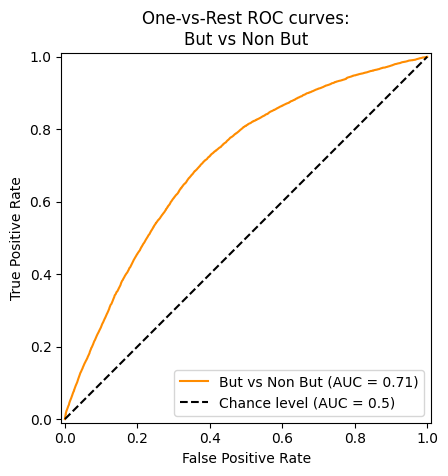

In [7]:
display = RocCurveDisplay.from_predictions(
    results_v0['is_goal'],
    results_v0['goal_proba'],
    name=f"But vs Non But",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\nBut vs Non But",
)

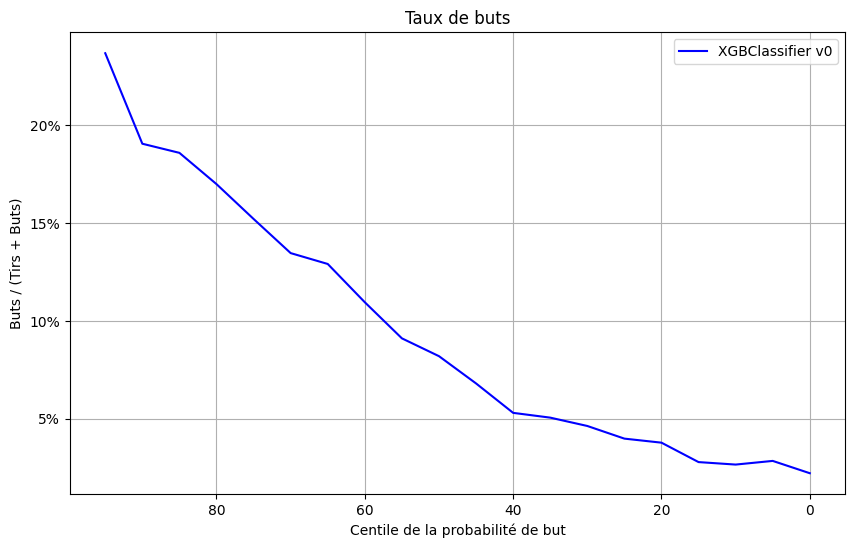

In [8]:
gr_df = results_v0.copy()

percentile_bins = np.linspace(0, 1, 21)
gr_df['percentile'] = pd.qcut(gr_df['goal_proba'], q=percentile_bins, labels=[p * 100 for p in percentile_bins[:-1]])
goal_rates = gr_df.groupby('percentile', observed=False)['is_goal'].mean()

plt.figure(figsize=(10, 6))
plt.plot(percentile_bins[:-1], goal_rates, color='blue', label='XGBClassifier v0')
plt.gca().invert_xaxis()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}%'))
plt.xlabel('Centile de la probabilité de but')
plt.ylabel('Buts / (Tirs + Buts)')
plt.title('Taux de buts')
plt.legend()
plt.grid()
plt.show()

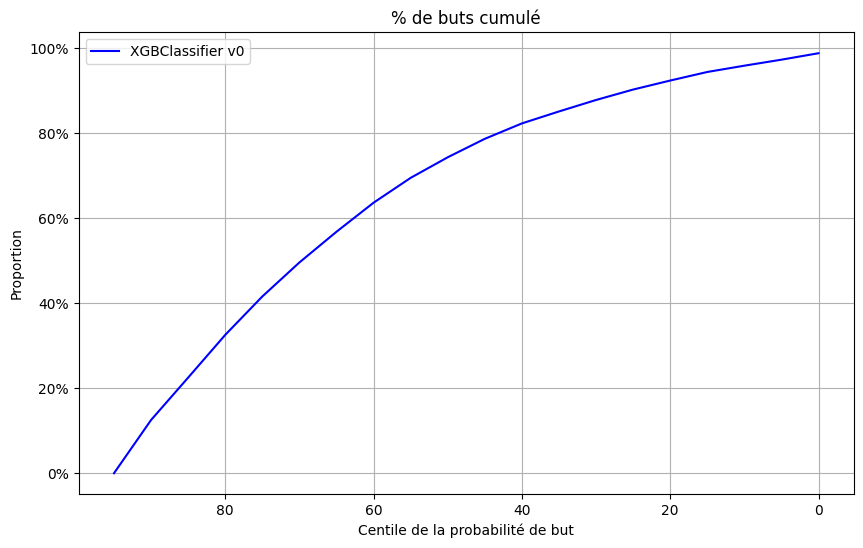

In [9]:
cg_df = results_v0.copy()

percentile_bins = np.linspace(0, 1, 21)
cg_df['percentile'] = pd.qcut(cg_df['goal_proba'], q=percentile_bins, labels=[p * 100 for p in percentile_bins[:-1]])
total_shots = cg_df['is_goal'].sum()
goals_cums = 1 - cg_df.groupby('percentile', observed=False)['is_goal'].sum().cumsum() / total_shots

plt.figure(figsize=(10, 6))
plt.plot(percentile_bins[:-1], goals_cums, color='blue', label='XGBClassifier v0')
plt.gca().invert_xaxis()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}%'))
plt.xlabel('Centile de la probabilité de but')
plt.ylabel('Proportion')
plt.title('% de buts cumulé')
plt.legend()
plt.grid()
plt.show()

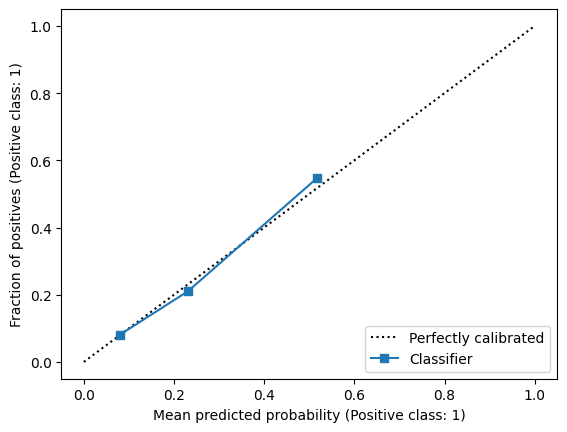

In [10]:
disp = CalibrationDisplay.from_predictions(y_val, results_v0['goal_proba'])
plt.show()

### XGBClassifier v1:
- Trained on all features
- Hyperparameters optimized

In [11]:
df1 = pd.get_dummies(df.drop(columns=['game_id', 'play_num']), columns=['shot_type'])
X1 = df1.drop(columns=['is_goal'])
y = df1['is_goal']

X_train_1, X_val_1, y_train, y_val = train_test_split(X1, y, test_size=0.3, random_state=42)

#### Scoring metric

There is a notable class imbalance in the dataset - 276763 class 0 data points for 29006 class 1 data points. Further - we are not interested in the classifier's ability to correctly label a shot as a goal or not. Instead, we are more focused on creating a classifier able to predict a realistic probability of goal. Given these requirements, I will choose **log-loss** as my scoring metric.

#### Hyperparameter optimization method
I do not have much experience optimizing XGBoost models and so do not have an intuition for which hyperparameter values to explore. Thus, I will **Bayesian Optimization** as it is capable of intelligently exploring different hyperparameter values without requiring them to be set ahead of time.

In [12]:
wandb.init(
    project="IFT6758.2024-A02",
    name="xgboost-v1",
    config={
        "cv_folds": 3,
        "eval_metric": "logloss",
        "model": "XGBClassifier",
    },
    reinit=True
)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }
    
    model = XGBClassifier(**params, eval_metric='logloss')
    
    score = cross_val_score(model, X_train_1, y_train, scoring='neg_log_loss', cv=3).mean()
    
    wandb.log({
        "trial_number": trial.number,
        "n_estimators": params['n_estimators'],
        "max_depth": params['max_depth'],
        "learning_rate": params['learning_rate'],
        "colsample_bytree": params['colsample_bytree'],
        "subsample": params['subsample'],
        "min_child_weight": params['min_child_weight'],
        "neg_log_loss": score
    })
    
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

wandb.config.update(study.best_params)

best_xgb_model = XGBClassifier(**study.best_params, eval_metric='logloss')
best_xgb_model.fit(X_train_1, y_train)

y_pred = best_xgb_model.predict(X_val_1)
y_pred_prob = best_xgb_model.predict_proba(X_val_1)[:, 1]

report = classification_report(y_val, y_pred, output_dict=True)
wandb.log(report)

accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_prob)
wandb.log({
    "accuracy": accuracy,
    "roc_auc": roc_auc,
})
print(f"Accuracy: {accuracy}", f"ROC AUC: {roc_auc}")

results_v1 = pd.DataFrame({
    'goal_proba': y_pred_prob,
    'non_goal_proba': 1 - y_pred_prob,
    'is_goal': y_val
})
wandb.log({"results_v1": wandb.Table(dataframe=results_v1)})

print("Best parameters:", study.best_params)
print("Classification report:")
print(classification_report(y_val, y_pred))

wandb.finish()

[I 2024-11-20 12:33:39,578] A new study created in memory with name: no-name-cd7804e1-8429-4cda-bbf4-28fd3d52559c
[I 2024-11-20 12:34:48,324] Trial 0 finished with value: -0.29434876401027005 and parameters: {'n_estimators': 340, 'max_depth': 8, 'learning_rate': 0.22307835615609947, 'colsample_bytree': 0.6066337778444726, 'subsample': 0.7684728407789925, 'min_child_weight': 1}. Best is trial 0 with value: -0.29434876401027005.
[I 2024-11-20 12:36:00,950] Trial 1 finished with value: -0.26279867558431547 and parameters: {'n_estimators': 489, 'max_depth': 6, 'learning_rate': 0.046334864527694246, 'colsample_bytree': 0.908917351271988, 'subsample': 0.8037874900865722, 'min_child_weight': 5}. Best is trial 1 with value: -0.26279867558431547.
[I 2024-11-20 12:36:38,876] Trial 2 finished with value: -0.2991526393493023 and parameters: {'n_estimators': 163, 'max_depth': 10, 'learning_rate': 0.28806635074351655, 'colsample_bytree': 0.9156602414141908, 'subsample': 0.5490758490515039, 'min_chil

Best parameters: {'n_estimators': 181, 'max_depth': 6, 'learning_rate': 0.0507232915643456, 'colsample_bytree': 0.9398551645840258, 'subsample': 0.7804076803777339, 'min_child_weight': 2}
Classification report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     83096
           1       0.87      0.06      0.11      8635

    accuracy                           0.91     91731
   macro avg       0.89      0.53      0.53     91731
weighted avg       0.91      0.91      0.87     91731



accuracy,▁
colsample_bytree,▂▇▇▃▆▃▆▄▁█▅█▄▅▅▂▇▇▆▇▇██▆▆▆▅▆▆▅▇▇▇▆▆██▇▇█
learning_rate,▆▂█▇▇▂▆▅▅▂▃▁▃▃▁▃▄▃▄▄▂▄▃▂▂▁▂▁▂▂▂▂█▅▂▂▃▆▂▃
max_depth,▆▄█▃▂▇▇▁▆▅█▆▅▇▄▃▄▃▅▃▄▁▅▅▆▆▆▆▇▄▅▅▅▄▅▄▅▄▃▄
min_child_weight,▁▄▇▃██▁▃▃▆▆▆▅█▆▄▅▃▅▆▅▃▆▅▆▃▄▄▃▄▄▂▁▂▂▁▂▂▃▁
n_estimators,█▃▆▇▆▆▄█▁▄▃▃▅▄▅▄▂▂▃▁▅▄▅▄▅▄▃▄▄▅▃▃▃▃▃▂▂▃▂▇
neg_log_loss,▂█▁▆▇█▆▄██▇▇▇▇█████████████████▅▃███▆██▇
subsample,▅▅▂▆▅▅▄▄█▃▃▃▂▂▇▇▇▇▇▆▇▆▁▁▁▁▂▁▃▂▄▄▄▅▄▅▄▅▅▆
trial_number,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
accuracy,0.91078
colsample_bytree,0.97347


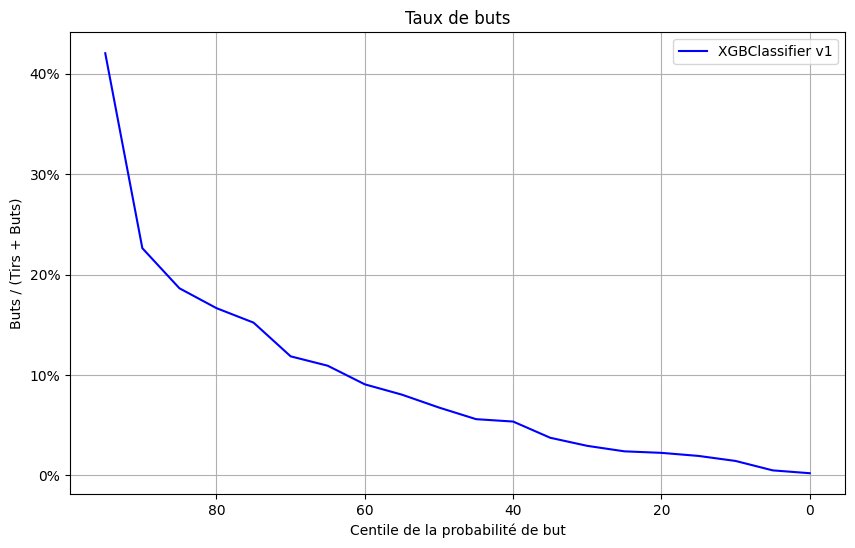

In [13]:
gr_df = results_v1.copy()

percentile_bins = np.linspace(0, 1, 21)
gr_df['percentile'] = pd.qcut(gr_df['goal_proba'], q=percentile_bins, labels=[p * 100 for p in percentile_bins[:-1]])
goal_rates = gr_df.groupby('percentile', observed=False)['is_goal'].mean()

plt.figure(figsize=(10, 6))
plt.plot(percentile_bins[:-1], goal_rates, color='blue', label='XGBClassifier v1')
plt.gca().invert_xaxis()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}%'))
plt.xlabel('Centile de la probabilité de but')
plt.ylabel('Buts / (Tirs + Buts)')
plt.title('Taux de buts')
plt.legend()
plt.grid()
plt.show()

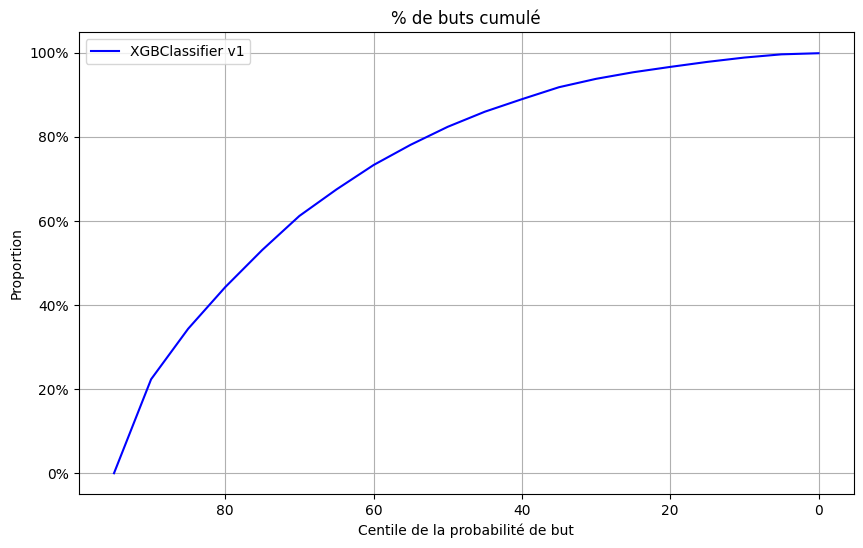

In [14]:
cg_df = results_v1.copy()

percentile_bins = np.linspace(0, 1, 21)
cg_df['percentile'] = pd.qcut(cg_df['goal_proba'], q=percentile_bins, labels=[p * 100 for p in percentile_bins[:-1]])
total_shots = cg_df['is_goal'].sum()
goals_cums = 1 - cg_df.groupby('percentile', observed=False)['is_goal'].sum().cumsum() / total_shots

plt.figure(figsize=(10, 6))
plt.plot(percentile_bins[:-1], goals_cums, color='blue', label='XGBClassifier v1')
plt.gca().invert_xaxis()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}%'))
plt.xlabel('Centile de la probabilité de but')
plt.ylabel('Proportion')
plt.title('% de buts cumulé')
plt.legend()
plt.grid()
plt.show()

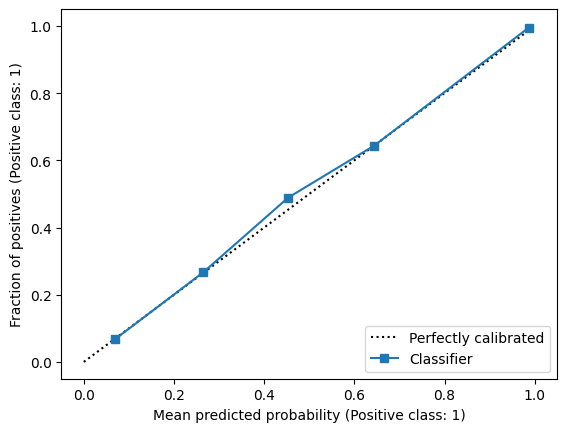

In [15]:
disp = CalibrationDisplay.from_predictions(y_val, results_v1['goal_proba'])
plt.show()

### XGBClassifier v2:
- Numeric data scaled
- Trained on select features
- Hyperparameters tuned

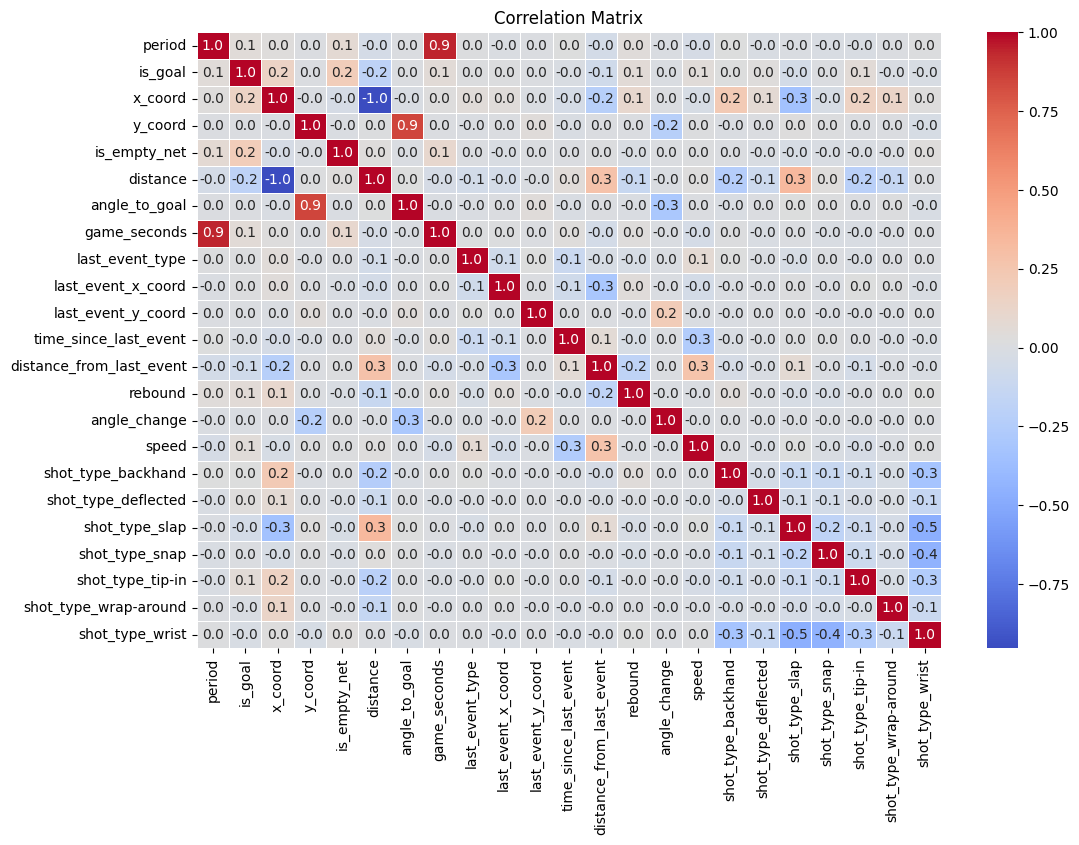

In [16]:
corr_matrix = df1.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.1f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [17]:
threshold = 0.9
to_drop = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            to_drop.add(colname)

df_reduced = df1.drop(columns=to_drop)
print(f"Dropped columns: {to_drop}")
print(f"Remaining columns: {df_reduced.columns}")

Dropped columns: {'game_seconds', 'distance'}
Remaining columns: Index(['period', 'is_goal', 'x_coord', 'y_coord', 'is_empty_net',
       'angle_to_goal', 'last_event_type', 'last_event_x_coord',
       'last_event_y_coord', 'time_since_last_event',
       'distance_from_last_event', 'rebound', 'angle_change', 'speed',
       'shot_type_backhand', 'shot_type_deflected', 'shot_type_slap',
       'shot_type_snap', 'shot_type_tip-in', 'shot_type_wrap-around',
       'shot_type_wrist'],
      dtype='object')


### SHAP

### Sklearn
Scaled values

In [30]:
df_2_train = pd.concat([X_train_1, y_train], axis=1)
df_2_train = df_2_train.dropna()

X_train_2 = df_2_train.drop(columns=['is_goal'])
y_train_2 = df_2_train['is_goal']

df_2_val = pd.concat([X_val_1, y_val], axis=1)
df_2_val = df_2_val.dropna()

X_val_2 = df_2_val.drop(columns=['is_goal'])
y_val_2 = df_2_val['is_goal']

print(X_train_1.shape, y_train.shape)
print(X_train_2.shape, y_train_2.shape)
print()
print(X_val_1.shape, y_val.shape)
print(X_val_2.shape, y_val_2.shape)


(214038, 22) (214038,)
(202545, 22) (202545,)

(91731, 22) (91731,)
(86741, 22) (86741,)


In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif

wandb.init(project="IFT6758.2024-A02", name="xgboost_v2")

wandb.config = {
    "model": "XGBoost",
    "scoring_metric": "roc_auc",
    "cv_folds": 3,
    "feature_selection": "mutual_info_classif",
    "classifier_params": study.best_params
}

numeric_features = [
    'period', 'x_coord', 'y_coord', 'is_empty_net', 'distance', 
    'angle_to_goal', 'game_seconds', 'last_event_x_coord', 
    'last_event_y_coord', 'time_since_last_event', 
    'distance_from_last_event', 'rebound', 'angle_change', 'speed'
]

boolean_features = [col for col in X_train_1.columns if col.startswith('shot_type_')]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('bool', 'passthrough', boolean_features)
    ]
)

feature_engineering_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('feature_selection', SelectKBest(mutual_info_classif, k='all'))
])

pipeline = Pipeline([
    ('feature_engineering', feature_engineering_pipeline),
    ('classifier', best_xgb_model)
])

cv_folds = wandb.config['cv_folds']
cv_scores = cross_val_score(pipeline, X_train_2, y_train_2, cv=cv_folds, scoring='roc_auc')
mean_cv_auc = cv_scores.mean()

wandb.log({"cross_val_mean_auc": mean_cv_auc})
print(f"XGBoost Model: Mean AUC = {mean_cv_auc:.4f}")

pipeline.fit(X_train_2, y_train_2)
test_score = pipeline.score(X_val_2, y_val_2)

wandb.log({"test_accuracy": test_score})
print(f"Test Accuracy = {test_score:.4f}")

wandb.finish()

XGBoost Model: Mean AUC = 0.7682
Test Accuracy = 0.9121


cross_val_mean_auc,▁
test_accuracy,▁
cross_val_mean_auc,0.76822
test_accuracy,0.91208


C:\Users\Dell.DESKTOP-4AU2O53\AppData\Local\Temp\ipykernel_11272\2538882130.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


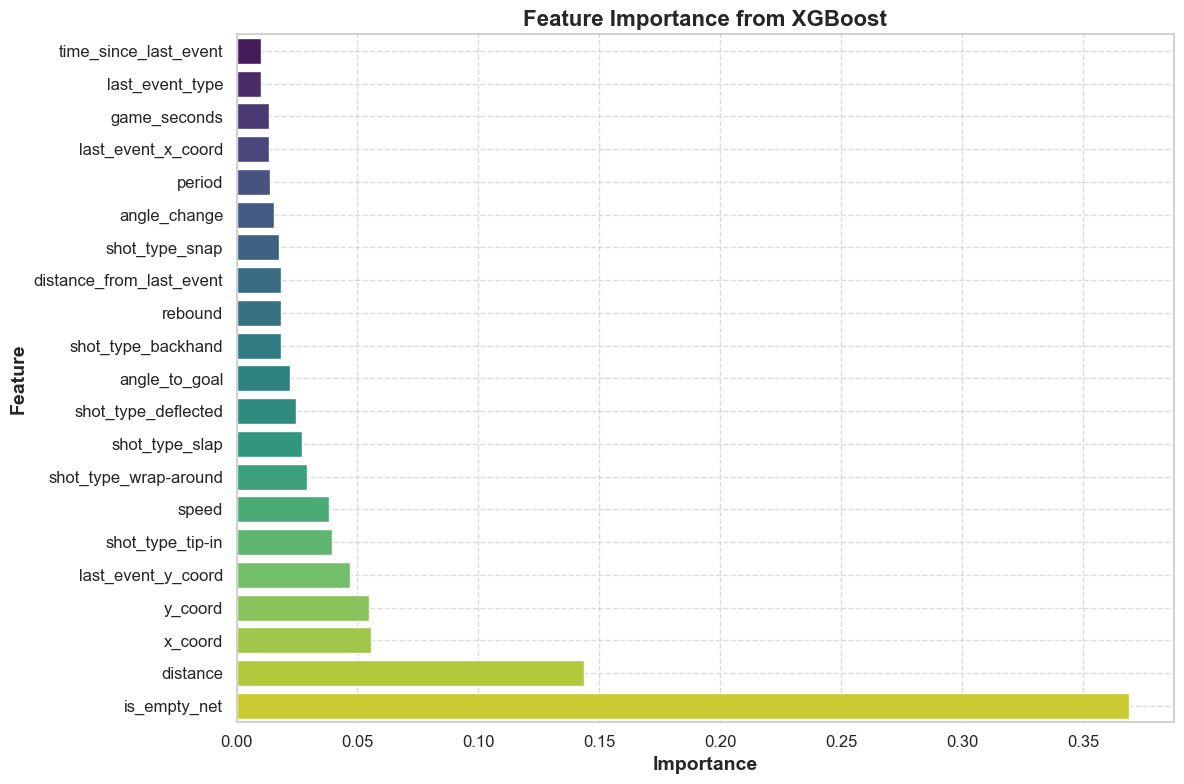

In [37]:
sns.set_theme(style="whitegrid")

xgb_model_v2 = pipeline.named_steps['classifier']

importances = xgb_model_v2.feature_importances_

selected_features = pipeline.named_steps['feature_engineering'].named_steps['feature_selection'].get_support(indices=True)
selected_feature_names = [X_train_2.columns[i] for i in selected_features]

feature_importance_df = pd.DataFrame({
    'feature': selected_feature_names,
    'importance': importances[selected_features]
})

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=True)

plt.figure(figsize=(12, 8))
ax = sns.barplot(
    x="importance", 
    y="feature", 
    data=feature_importance_df, 
    palette="viridis",
    orient="h"
)

ax.set_xlabel('Importance', fontsize=14, weight='bold')
ax.set_ylabel('Feature', fontsize=14, weight='bold')
ax.set_title('Feature Importance from XGBoost', fontsize=16, weight='bold')

ax.tick_params(axis='both', labelsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()